# Mental Health Data Analysis on Reddit (Transform Phase)


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql_db_connection.db_connection import (
    create_mental_disorders_reddit_engine,
    get_mental_disorders_table_conf,
)

## Load the data frame

### Create a database engine connection


In [42]:
engine = create_mental_disorders_reddit_engine()

### Load the dataset from the database


In [43]:
mental_disorders_table_name = get_mental_disorders_table_conf()["name"]
query = f"SELECT * FROM {mental_disorders_table_name}"
df = pd.read_sql(query, engine)
df.head()

,title,selftext,created_utc,over_18,subreddit
0,Life is so pointless without others,Does anyone else think the most important part...,1650356960,0,BPD
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,0,BPD
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,0,BPD
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,0,BPD
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",1650350635,0,BPD


### Display dataset information


In [44]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570329 entries, 0 to 570328
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        570329 non-null  object
 1   selftext     570329 non-null  object
 2   created_utc  570329 non-null  int64 
 3   over_18      570329 non-null  int64 
 4   subreddit    570329 non-null  object
dtypes: int64(2), object(3)
memory usage: 21.8+ MB


,created_utc,over_18
count,5.703290e+05,570329.000000
mean,1.622377e+09,0.023893
std,4.804873e+07,0.152717
min,1.308582e+09,0.000000
25%,1.609714e+09,0.000000
50%,1.638846e+09,0.000000
75%,1.654116e+09,0.000000
max,1.669253e+09,1.000000


## Data analysis

### Plot the number of posts per subreddit


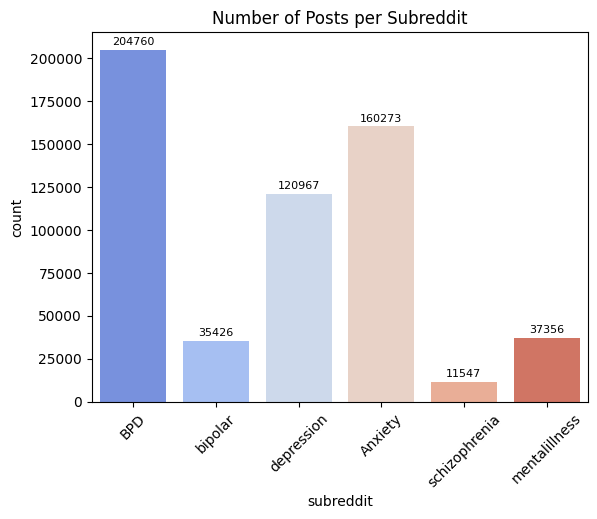

In [45]:
ax = sns.countplot(x=df["subreddit"], hue=df["subreddit"], palette="coolwarm")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=8, padding=2)

plt.title("Number of Posts per Subreddit")
plt.xticks(rotation=45)
plt.show()

### Converting Unix Timestamp to DateTime Format

In [46]:
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s")
df.head()

,title,selftext,created_utc,over_18,subreddit
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,0,BPD
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,2022-04-19 08:24:20,0,BPD
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,0,BPD
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,0,BPD
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,0,BPD


### Extract date-related features


In [47]:
df["date"] = df["created_utc"].dt.date
df["hour"] = df["created_utc"].dt.hour
df["day_of_week"] = df["created_utc"].dt.day_name()
df["month"] = df["created_utc"].dt.month
df["year"] = df["created_utc"].dt.year
df.head()

,title,selftext,created_utc,over_18,subreddit,date,hour,day_of_week,month,year
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,0,BPD,2022-04-19,8,Tuesday,4,2022
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,2022-04-19 08:24:20,0,BPD,2022-04-19,8,Tuesday,4,2022
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,0,BPD,2022-04-19,8,Tuesday,4,2022
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,0,BPD,2022-04-19,7,Tuesday,4,2022
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,0,BPD,2022-04-19,6,Tuesday,4,2022


### Plot the number of posts per day


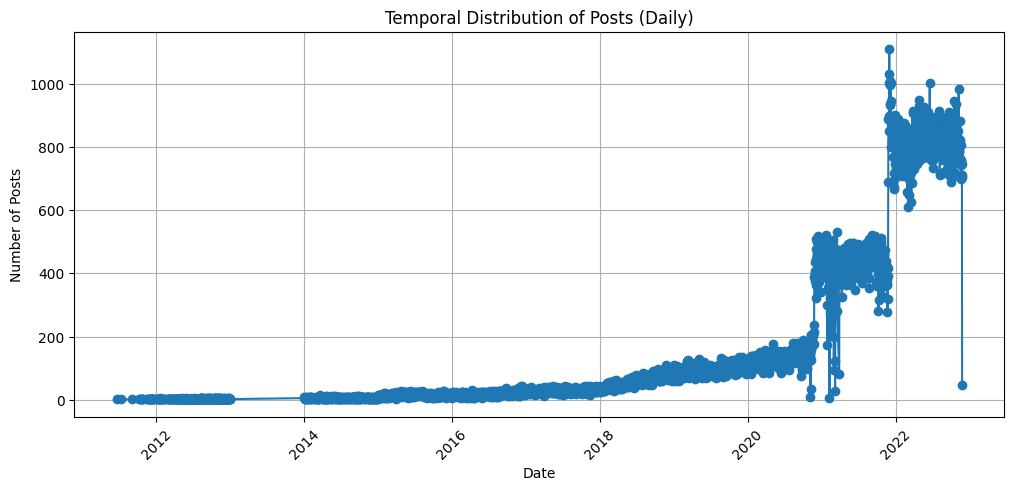

In [48]:
posts_per_day = df.groupby("date").size()

plt.figure(figsize=(12, 5))
plt.plot(posts_per_day, marker="o")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.title("Temporal Distribution of Posts (Daily)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Plot the distribution of posts by hour


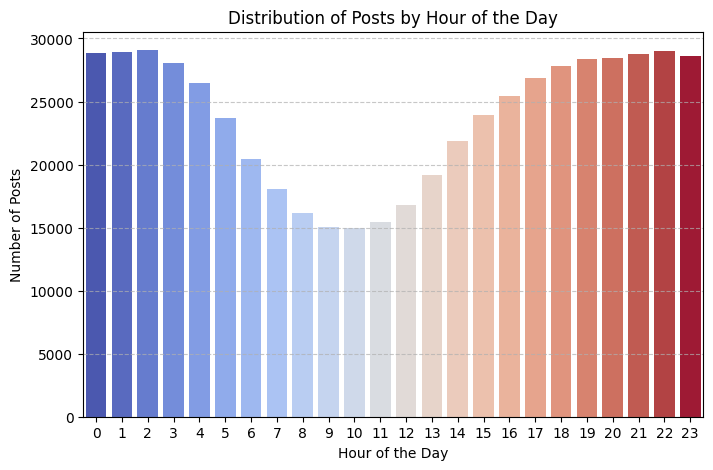

In [49]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["hour"], hue=df["hour"], palette="coolwarm", legend=False)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Posts")
plt.title("Distribution of Posts by Hour of the Day")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Analysis based on selftext column

### Compute selftext statistics


In [50]:
def repetition_ratio(text, total_words):
    unique_words = len(set(text.split()))
    return total_words / unique_words

df["selftext_length"] = df["selftext"].apply(len)
df["word_count"] = df["selftext"].apply(lambda x: len(x.split()))
df["avg_word_length"] = df["selftext_length"] / df["word_count"]
df["repetition_ratio"] = [
    repetition_ratio(text, word_count)
    for text, word_count in zip(df["selftext"], df["word_count"])
]
df.head()

,title,selftext,created_utc,over_18,subreddit,date,hour,day_of_week,month,year,selftext_length,word_count,avg_word_length,repetition_ratio
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,0,BPD,2022-04-19,8,Tuesday,4,2022,384,74,5.189189,1.345455
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,2022-04-19 08:24:20,0,BPD,2022-04-19,8,Tuesday,4,2022,2783,517,5.382979,1.776632
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,0,BPD,2022-04-19,8,Tuesday,4,2022,689,145,4.751724,1.790123
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,0,BPD,2022-04-19,7,Tuesday,4,2022,4138,821,5.040195,2.166227
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,0,BPD,2022-04-19,6,Tuesday,4,2022,1119,202,5.539604,1.383562


### Plot the distribution of selftext length


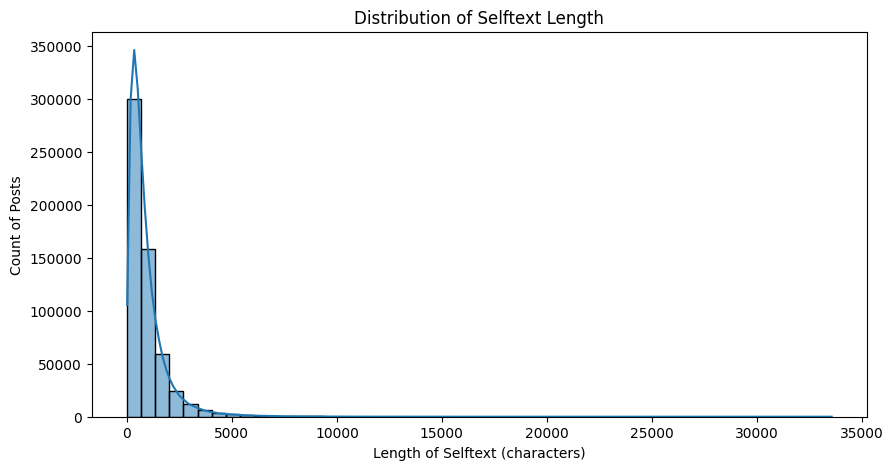

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(df["selftext_length"], bins=50, kde=True)
plt.xlabel("Length of Selftext (characters)")
plt.ylabel("Count of Posts")
plt.title("Distribution of Selftext Length")
plt.show()

### Boxplot analysis for selftext lenght and word count


In [52]:
df_graphic_analysis_copy = df.copy()

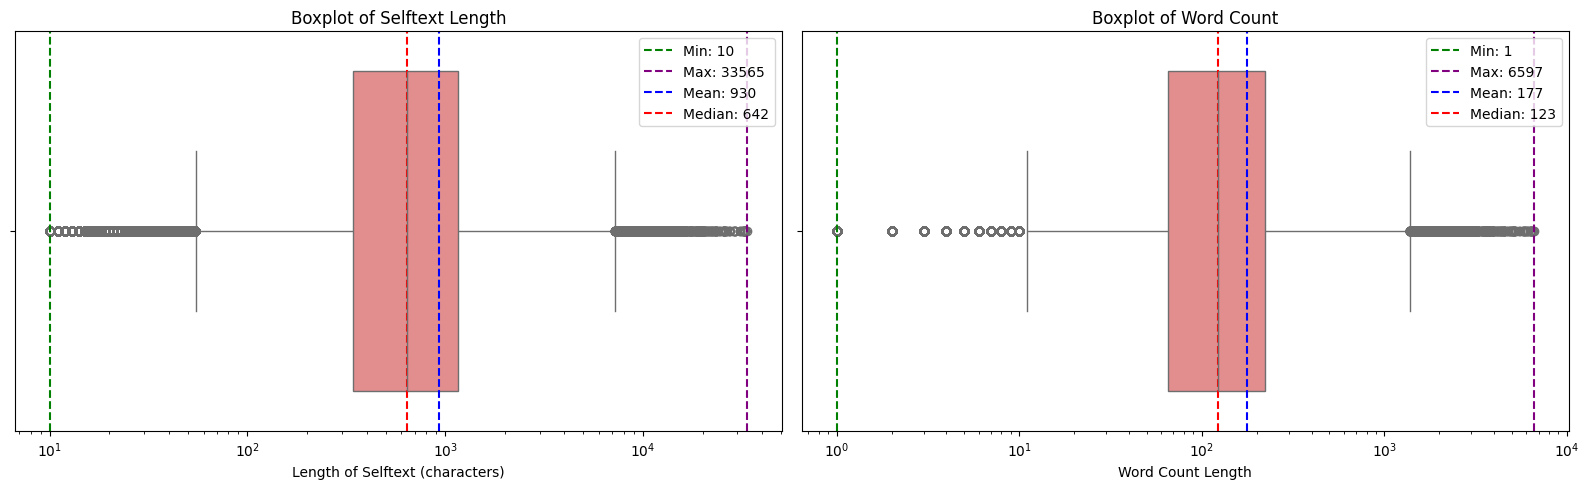

In [53]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
ax = sns.boxplot(
    x=df_graphic_analysis_copy["selftext_length"], color="lightcoral", log_scale=True
)
ax.axvline(
    df_graphic_analysis_copy["selftext_length"].min(),
    color="green",
    linestyle="--",
    label=f"Min: {df_graphic_analysis_copy['selftext_length'].min():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["selftext_length"].max(),
    color="purple",
    linestyle="--",
    label=f"Max: {df_graphic_analysis_copy['selftext_length'].max():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["selftext_length"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df_graphic_analysis_copy['selftext_length'].mean():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["selftext_length"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df_graphic_analysis_copy['selftext_length'].median():.0f}",
)
plt.xlabel("Length of Selftext (characters)")
plt.title("Boxplot of Selftext Length")
plt.legend()

plt.subplot(1, 2, 2)
ax = sns.boxplot(
    x=df_graphic_analysis_copy["word_count"], color="lightcoral", log_scale=True
)
ax.axvline(
    df_graphic_analysis_copy["word_count"].min(),
    color="green",
    linestyle="--",
    label=f"Min: {df_graphic_analysis_copy['word_count'].min():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["word_count"].max(),
    color="purple",
    linestyle="--",
    label=f"Max: {df_graphic_analysis_copy['word_count'].max():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["word_count"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df_graphic_analysis_copy['word_count'].mean():.0f}",
)
ax.axvline(
    df_graphic_analysis_copy["word_count"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df_graphic_analysis_copy['word_count'].median():.0f}",
)
plt.xlabel("Word Count Length")
plt.title("Boxplot of Word Count")
plt.legend()

plt.tight_layout()
plt.show()

### Scatterplot of the relationship between word count and selftext length


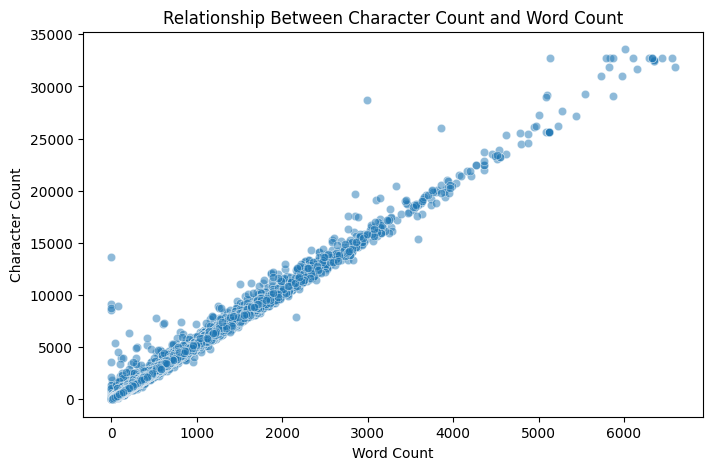

In [54]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_graphic_analysis_copy["word_count"],
    y=df_graphic_analysis_copy["selftext_length"],
    alpha=0.5,
)
plt.xlabel("Word Count")
plt.ylabel("Character Count")
plt.title("Relationship Between Character Count and Word Count")
plt.show()

### Distribution of Repetition Ratio with Threshold line based in 99th percentile

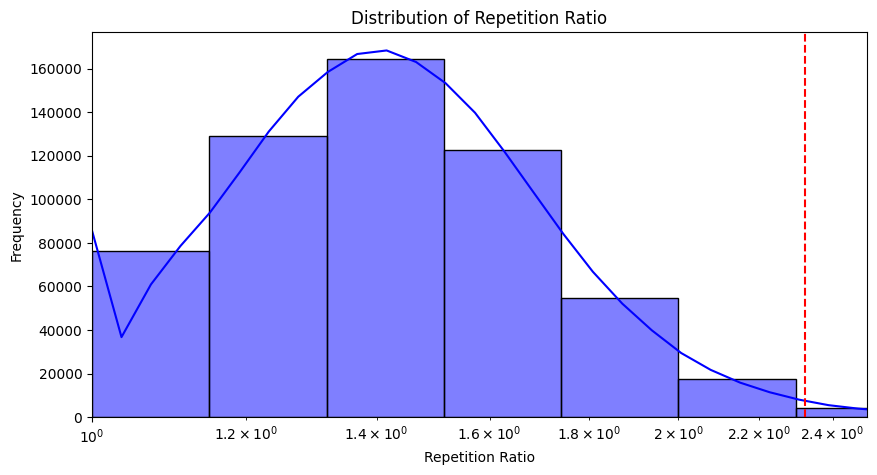

count    570329.000000
mean          1.488968
std           3.791218
min           1.000000
25%           1.244444
50%           1.410714
75%           1.602941
max        1024.000000
Name: repetition_ratio, dtype: float64

Threshold for repetition ratio based on the 99th percentile:  2.3227488453575407


In [55]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df_graphic_analysis_copy["repetition_ratio"],
    bins=50,
    kde=True,
    color="blue",
    log_scale=True,
)
plt.xlim(1, 2.5)

repetition_ratio_threshold = df_graphic_analysis_copy["repetition_ratio"].quantile(0.99)

plt.axvline(repetition_ratio_threshold, color="red", linestyle="dashed")
plt.xlabel("Repetition Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Repetition Ratio")
plt.show()
print(df_graphic_analysis_copy["repetition_ratio"].describe())
print(
    f"\nThreshold for repetition ratio based on the 99th percentile: ",
    repetition_ratio_threshold,
)

### Distribution of Average Word Length with Thresholds 

High Threshold: 7.65


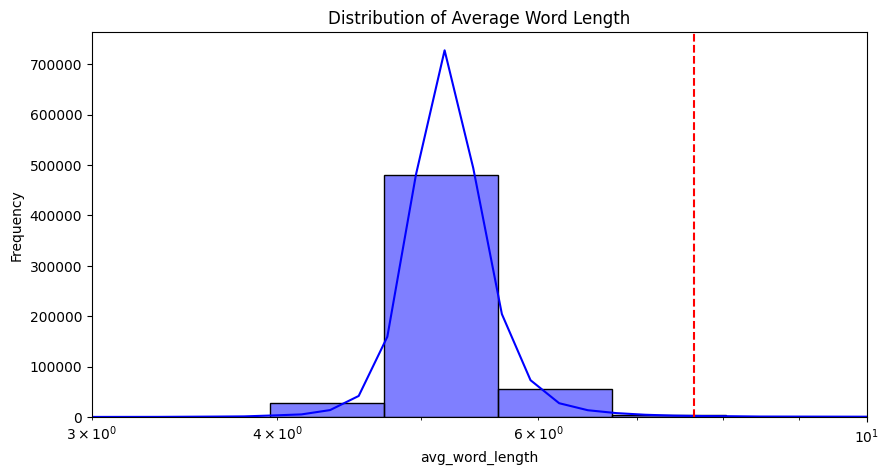

count    570329.000000
mean          5.408456
std          28.006973
min           1.950000
25%           5.022222
50%           5.209302
75%           5.420000
max       13640.000000
Name: avg_word_length, dtype: float64

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(
    df_graphic_analysis_copy["avg_word_length"],
    bins=50,
    kde=True,
    color="blue",
    log_scale=True,
)

avg_word_length_threshold = df_graphic_analysis_copy["avg_word_length"].quantile(
    0.995
)
print(f"High Threshold: {avg_word_length_threshold:.2f}")

plt.axvline(avg_word_length_threshold, color="red", linestyle="dashed")

plt.title("Distribution of Average Word Length")
plt.xlim(3, 10)
plt.ylabel("Frequency")
plt.show()

df_graphic_analysis_copy["avg_word_length"].describe()

## Filtering rows based on selftext statistics


### Filtering rows based on selftext length (2nd and 99th percentile)

In [57]:
selftext_length_low_threshold, selftext_length_high_threshold = df[
    "selftext_length"
].quantile([0.02, 0.99])
selftext_length_mask = (df["selftext_length"] >= selftext_length_low_threshold) & (
    df["selftext_length"] <= selftext_length_high_threshold
)
df = df[selftext_length_mask]

print(f"Number of texts removed: {(~selftext_length_mask).sum()}")
print(f"Number of texts remaining: {selftext_length_mask.sum()}")

Number of texts removed: 16999
Number of texts remaining: 553330


### Filtering rows based on word count (2.2nd and 99.7th percentile)


In [58]:
word_count_min_threshold, word_count_max_threshold = df["word_count"].quantile(
    [0.022, 0.997]
)
word_count_length_mask = (df["word_count"] >= word_count_min_threshold) & (
    df["word_count"] <= word_count_max_threshold
)
df = df[word_count_length_mask]

print(f"Number of texts removed: {(~word_count_length_mask).sum()}")
print(f"Number of texts remaining: {word_count_length_mask.sum()}")

Number of texts removed: 12653
Number of texts remaining: 540677


### Boxplot analysis for selftext lenght and word count after the filter


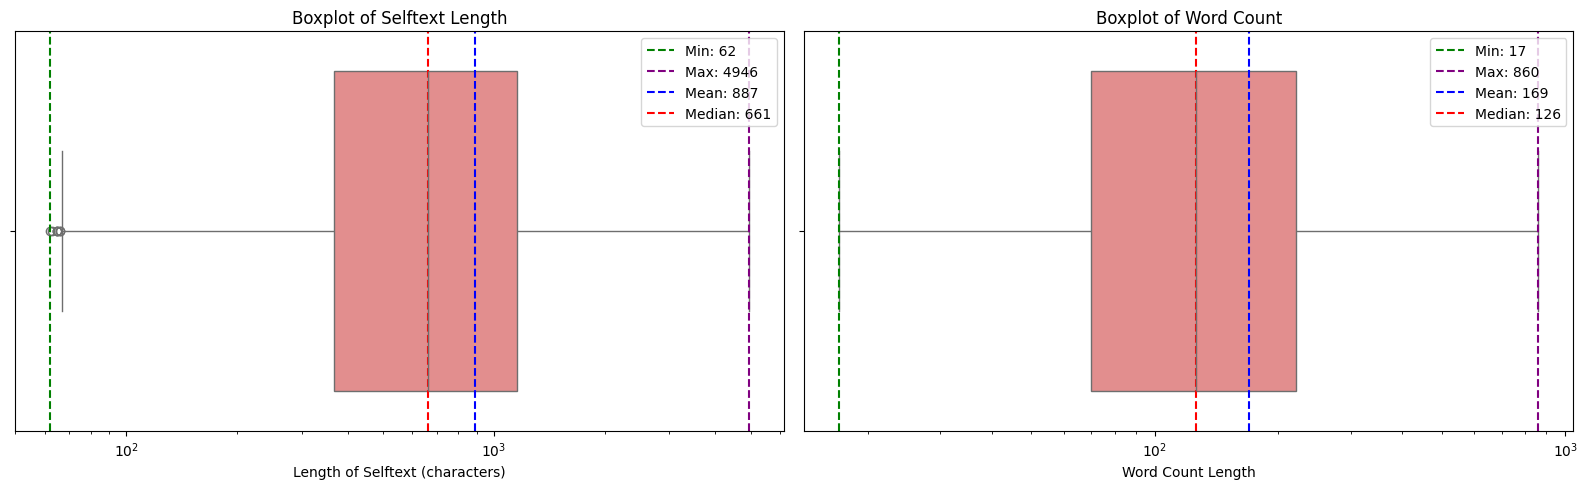

In [59]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
ax = sns.boxplot(x=df["selftext_length"], color="lightcoral", log_scale=True)
ax.axvline(
    df["selftext_length"].min(),
    color="green",
    linestyle="--",
    label=f"Min: {df['selftext_length'].min():.0f}",
)
ax.axvline(
    df["selftext_length"].max(),
    color="purple",
    linestyle="--",
    label=f"Max: {df['selftext_length'].max():.0f}",
)
ax.axvline(
    df["selftext_length"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df['selftext_length'].mean():.0f}",
)
ax.axvline(
    df["selftext_length"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df['selftext_length'].median():.0f}",
)
plt.xlabel("Length of Selftext (characters)")
plt.title("Boxplot of Selftext Length")
plt.legend()

plt.subplot(1, 2, 2)
ax = sns.boxplot(x=df["word_count"], color="lightcoral", log_scale=True)
ax.axvline(
    df["word_count"].min(),
    color="green",
    linestyle="--",
    label=f"Min: {df['word_count'].min():.0f}",
)
ax.axvline(
    df["word_count"].max(),
    color="purple",
    linestyle="--",
    label=f"Max: {df['word_count'].max():.0f}",
)
ax.axvline(
    df["word_count"].mean(),
    color="blue",
    linestyle="--",
    label=f"Mean: {df['word_count'].mean():.0f}",
)
ax.axvline(
    df["word_count"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df['word_count'].median():.0f}",
)
plt.xlabel("Word Count Length")
plt.title("Boxplot of Word Count")
plt.legend()

plt.tight_layout()
plt.show()

  ### Filter Texts Based on repetition ratio Thresholds


In [60]:
repetition_ratio_mask = df["repetition_ratio"] <= repetition_ratio_threshold

df = df[repetition_ratio_mask]

print(f"Number of texts removed: {(~repetition_ratio_mask).sum()}")
print(f"Number of texts remaining: {repetition_ratio_mask.sum()}")


Number of texts removed: 1850
Number of texts remaining: 538827


### Filter Texts Based on Average Word Length Threshold


In [61]:
avg_word_length_mask = (df["avg_word_length"] <= avg_word_length_threshold)
df = df[avg_word_length_mask]

print(f"Number of texts removed: {(~avg_word_length_mask).sum()}")
print(f"Number of texts remaining: {avg_word_length_mask.sum()}")

Number of texts removed: 1290
Number of texts remaining: 537537


### Filter rows with URLs in the 'selftext' column

In [62]:
import html

def clean_text(text):
    return html.unescape(text) if isinstance(text, str) else text


df["selftext"] = df["selftext"].apply(clean_text)
url_pattern = r"https?://\S+|www\.\S+|\[.*?\]\(https?://\S+\)"
only_links_mask = df["selftext"].str.contains(
    url_pattern, case=False, na=False, regex=True
)
df = df[~only_links_mask]

print("Number of selftexts containing links: ", only_links_mask.sum())

Number of selftexts containing links:  5568


### Create a random sample of 100000 posts

In [63]:
df_copy = df.sample(n=100000, random_state=42).copy()

## Emotion Anlaysis


### Import Emotion Analysis Functions


In [64]:
from utils.emotions_analysis import (
    get_tokenized_text,
    get_most_common_word,
    detect_emotions,
    get_primary_emotion,
    get_vader_sentiment_label,
    get_vader_compound_score,
)

### Tokenize Selftext Column


In [65]:
df_copy["selftext_tokenized"] = df_copy["selftext"].apply(get_tokenized_text)

### Detect Emotions and Sentiment from Tokenized Text


In [66]:
df_copy[["nrc_emotion_scores", "nrc_sentiment"]] = df_copy["selftext_tokenized"].apply(
    lambda x: pd.Series(detect_emotions(x))
)

### Extract Primary Emotion from NRC Emotion Scores

In [67]:
df_copy["nrc_primary_emotion"] = df_copy["nrc_emotion_scores"].apply(
    get_primary_emotion
)

### Calculate VADER Compound Score for Selftext


In [68]:
df_copy["vader_compound_score"] = df_copy["selftext"].apply(get_vader_compound_score)

### Assign VADER Sentiment Label Based on Compound Score


In [69]:
df_copy["vader_sentiment_label"] = df_copy["vader_compound_score"].apply(
    get_vader_sentiment_label
)

### Extract Most Common Word from Tokenized Selftext


In [70]:
df_copy["most_common_word"] = df_copy["selftext_tokenized"].apply(get_most_common_word)

### Drop Unnecessary Columns from DataFrame


In [71]:
columns_to_drop = [
    "over_18",
    "created_utc",
    "avg_word_length",
    "selftext_length",
    "vader_compound_score",
    "selftext_tokenized",
    "nrc_emotion_scores",
]
df_copy = df_copy.drop(columns=columns_to_drop)

In [72]:
df_copy.head()

,title,selftext,subreddit,date,hour,day_of_week,month,year,word_count,repetition_ratio,nrc_sentiment,nrc_primary_emotion,vader_sentiment_label,most_common_word
235290,I feel so unreasonably angry as of late.,For the last few days I’ve been a lot more irr...,bipolar,2022-08-17,23,Wednesday,8,2022,107,1.389610,negative,anger,negative,like
502741,can’t sleep because of asbestos fear,we just moved into a new house and it has popc...,Anxiety,2021-08-29,0,Sunday,8,2021,135,1.391753,negative,sadness,negative,ceilings
399629,does anyone else experience anxiety over a ser...,Ex: I started watching the vampire diaries and...,Anxiety,2022-03-28,1,Monday,3,2022,86,1.303030,negative,trust,negative,watching
381427,"Just graduated my degree, just spent 3 months ...",I’ve never felt like this in my life. January ...,Anxiety,2022-01-14,14,Friday,1,2022,114,1.357143,neutral,sadness,negative,never
501429,Anyone else feel anxious in the inside?,Like my body is calm but my insides feel all a...,Anxiety,2020-12-12,22,Saturday,12,2020,21,1.166667,negative,fear,negative,like


In [78]:
import os
os.system("jupyter nbconvert --to html --log-level=ERROR EDA_transformation.ipynb")

0